In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8
!ls "/content/drive/MyDrive/My First Project.v15i.yolov11"


data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [4]:
!pip install ultralytics torch torchvision opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [5]:
!pip install ultralytics

In [6]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import glob
from PIL import Image
import numpy as np

In [8]:
DATASET_PATH = "/content/drive/MyDrive/My First Project.v15i.yolov11"  # Change to your dataset path
IMG_SIZE = 416  # Image size for training

import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Example Vision Transformer

# Load YOLOv10m model
model = YOLO("yolo12m.pt")




100%|██████████| 39.0M/39.0M [00:00<00:00, 50.6MB/s]


In [9]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Small Vision Transformer

class HybridBackbone(nn.Module):
    def __init__(self, yolo_backbone, transformer):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.transformer = transformer

    def forward(self, x):
        # Extract features using YOLO's CNN backbone
        cnn_features = self.yolo_backbone(x)

        # Transformer expects a different input shape, so adjust it
        b, c, h, w = cnn_features.shape
        cnn_features = cnn_features.view(b, c, -1).permute(2, 0, 1)  # Reshape for transformer input

        # Extract transformer features
        transformer_features = self.transformer(cnn_features)

        # Reshape back to CNN format
        transformer_features = transformer_features.permute(1, 2, 0).view(b, c, h, w)

        return transformer_features

# Extract YOLO's original backbone
yolo_backbone = model.model.model[0]  # This extracts YOLO's backbone

# Load a pretrained Vision Transformer
transformer = vit_b_16(pretrained=True)
transformer.heads = nn.Identity()  # Remove classification head

# Create a new hybrid backbone
hybrid_backbone = HybridBackbone(yolo_backbone, transformer)

# Replace YOLO's backbone with the hybrid version
model.model.model[0] = hybrid_backbone


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 168MB/s]


In [10]:
model.train(
    epochs=50,
    batch=16,
    imgsz=416,
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=6,  # Early stopping with patience 6

    data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml",
)

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo12m.pt, data=/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml, epochs=50, time=None, patience=6, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

100%|██████████| 755k/755k [00:00<00:00, 71.7MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2689536  ultralytics.nn.modules.block.A2C2f           [512, 512, 2, True, 4]        
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/train/labels.cache... 2436 images, 420 backgrounds, 0 corrupt: 100%|██████████| 2436/2436 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 123 weight(decay=0.0), 130 weight(decay=0.0005), 129 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.49G      2.098       3.66       2.06         19        416: 100%|██████████| 153/153 [11:50<00:00,  4.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.20it/s]

                   all        266        295      0.264     0.0498     0.0029   0.000798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.23G       2.27      3.449      2.152          6        416: 100%|██████████| 153/153 [00:59<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]


                   all        266        295     0.0595      0.215     0.0326     0.0138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.26G      2.206      3.402      2.113          2        416: 100%|██████████| 153/153 [00:57<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        266        295      0.294     0.0981     0.0215    0.00682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.36G      2.119      3.241      2.023          9        416: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


                   all        266        295      0.139      0.152      0.107     0.0457

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.67G      2.087      3.188      1.986          4        416: 100%|██████████| 153/153 [00:57<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


                   all        266        295      0.121      0.189     0.0986      0.035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.67G      1.986      3.086      1.908          5        416: 100%|██████████| 153/153 [00:57<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


                   all        266        295       0.18      0.308     0.0991     0.0399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      5.67G      1.983      2.983      1.903          8        416: 100%|██████████| 153/153 [00:57<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


                   all        266        295      0.166      0.194      0.122     0.0506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      5.67G      1.909      2.871      1.851          7        416: 100%|██████████| 153/153 [00:58<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


                   all        266        295      0.248      0.203      0.161     0.0672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.67G        1.9      2.866      1.848          5        416: 100%|██████████| 153/153 [00:57<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


                   all        266        295      0.287      0.276      0.213     0.0994

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      5.67G      1.877      2.826      1.809          9        416: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


                   all        266        295      0.188        0.2      0.146     0.0658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      5.67G      1.855      2.751        1.8          8        416: 100%|██████████| 153/153 [00:57<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        266        295      0.244      0.284      0.209     0.0985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      5.67G      1.827      2.747      1.799          7        416: 100%|██████████| 153/153 [00:58<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.12it/s]


                   all        266        295       0.28      0.217      0.206     0.0963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      5.67G       1.82      2.709      1.799         10        416: 100%|██████████| 153/153 [00:57<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.61it/s]


                   all        266        295      0.165      0.327      0.214     0.0887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      5.67G      1.776      2.674      1.763          8        416: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.01it/s]

                   all        266        295      0.263      0.276      0.238       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      5.67G      1.755      2.608      1.737          8        416: 100%|██████████| 153/153 [00:57<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]


                   all        266        295      0.218       0.31      0.258      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      5.67G      1.755      2.584      1.731          9        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]


                   all        266        295      0.301      0.285      0.263      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.67G      1.723      2.552      1.726          8        416: 100%|██████████| 153/153 [00:57<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]

                   all        266        295      0.272      0.284      0.269      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      5.67G      1.751      2.532      1.739         17        416: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


                   all        266        295      0.266      0.293      0.289      0.147

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.67G      1.737      2.507      1.722          6        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


                   all        266        295      0.319      0.339      0.303      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.67G      1.716      2.476       1.73          7        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


                   all        266        295      0.277      0.346      0.295      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      5.67G      1.692      2.443      1.688          4        416: 100%|██████████| 153/153 [00:57<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]

                   all        266        295      0.286      0.328        0.3      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      5.67G      1.685       2.44        1.7          3        416: 100%|██████████| 153/153 [00:57<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.08it/s]

                   all        266        295      0.335      0.341        0.3      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      5.67G      1.694      2.417      1.694          6        416: 100%|██████████| 153/153 [00:58<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]


                   all        266        295      0.309      0.356      0.295      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      5.67G      1.656      2.402      1.709          3        416: 100%|██████████| 153/153 [00:57<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

                   all        266        295      0.309      0.371      0.306      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      5.67G      1.646      2.346      1.688          8        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]

                   all        266        295      0.357      0.338      0.312      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      5.67G      1.653      2.328      1.672          7        416: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.07it/s]

                   all        266        295      0.361      0.365      0.343      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      5.67G      1.617      2.284      1.668          9        416: 100%|██████████| 153/153 [00:57<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


                   all        266        295      0.358       0.34      0.351      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      5.67G      1.593      2.249       1.63          7        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        266        295      0.429       0.35      0.349      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.67G      1.597      2.219      1.633          8        416: 100%|██████████| 153/153 [00:57<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

                   all        266        295      0.422      0.415       0.38      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.67G      1.598      2.231      1.634         12        416: 100%|██████████| 153/153 [00:57<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all        266        295      0.423      0.392      0.383      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.67G      1.603      2.241      1.635          6        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

                   all        266        295       0.42       0.38      0.372       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.67G      1.587       2.17      1.631         17        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all        266        295      0.378       0.43      0.393      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      5.67G       1.57       2.17      1.623          9        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.12it/s]

                   all        266        295      0.397      0.443      0.397      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      5.67G      1.562      2.135      1.617         15        416: 100%|██████████| 153/153 [00:58<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


                   all        266        295      0.425      0.422      0.391        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.67G      1.537       2.12      1.603          5        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.68it/s]

                   all        266        295      0.411      0.455      0.422      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.67G       1.54      2.108      1.605         12        416: 100%|██████████| 153/153 [00:57<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.13it/s]

                   all        266        295      0.399      0.432      0.408      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.67G      1.553      2.067      1.606          6        416: 100%|██████████| 153/153 [00:58<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

                   all        266        295      0.496      0.407      0.405      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      5.67G      1.516      2.037       1.59          4        416: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


                   all        266        295      0.458      0.461      0.428      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      5.67G      1.502      1.999      1.579          7        416: 100%|██████████| 153/153 [00:57<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.12it/s]

                   all        266        295      0.458      0.428      0.436       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.67G      1.493      2.002      1.561          6        416: 100%|██████████| 153/153 [00:57<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]

                   all        266        295      0.453      0.488      0.453      0.247


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      5.67G      1.527      1.856      1.615          4        416: 100%|██████████| 153/153 [00:58<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


                   all        266        295      0.464      0.494       0.46      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      5.67G      1.493        1.8      1.609          3        416: 100%|██████████| 153/153 [00:56<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]

                   all        266        295      0.489      0.536      0.489      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      5.67G      1.487       1.74      1.594          6        416: 100%|██████████| 153/153 [00:56<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]


                   all        266        295      0.491      0.527       0.48       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      5.67G      1.465      1.668      1.584          6        416: 100%|██████████| 153/153 [00:56<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.52it/s]

                   all        266        295      0.475      0.554      0.471      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      5.67G       1.45      1.661      1.564         10        416: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        266        295      0.501      0.495       0.49      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      5.67G      1.447      1.627      1.559          5        416: 100%|██████████| 153/153 [00:57<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.66it/s]

                   all        266        295      0.482      0.518       0.49      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      5.67G      1.436      1.613      1.564          9        416: 100%|██████████| 153/153 [00:56<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]

                   all        266        295      0.506      0.543      0.498      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.67G      1.415      1.595      1.538          6        416: 100%|██████████| 153/153 [01:01<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

                   all        266        295      0.509       0.53      0.513      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.67G       1.39      1.561       1.52          4        416: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all        266        295      0.516      0.526      0.516      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.67G      1.383      1.534      1.517          5        416: 100%|██████████| 153/153 [00:58<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


                   all        266        295      0.635      0.466      0.532      0.293

50 epochs completed in 1.064 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.29it/s]


                   all        266        295      0.638      0.466      0.532      0.293
                 cloth         49         68       0.66      0.485      0.557      0.334
                 glass         60         60      0.805      0.687      0.763      0.389
                 metal         45         55      0.525      0.327      0.358       0.18
               plastic         80        112      0.564      0.366       0.45      0.269
Speed: 0.1ms preprocess, 6.3ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79e4054d4550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [11]:
metrics = model.val()  # Validate the model

# Extract values correctly
precision = metrics.box.p.mean()  # Mean Precision
recall = metrics.box.r.mean()  # Mean Recall
map50 = metrics.box.map50  # Mean Average Precision @ 50
map50_95 = metrics.box.map  # Mean Average Precision @ 50-95

# Print metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, mAP@50: {map50:.4f}, mAP@50-95: {map50_95:.4f}")

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:07<00:00,  2.42it/s]


                   all        266        295      0.623      0.465       0.53      0.292
                 cloth         49         68      0.646      0.485      0.558      0.334
                 glass         60         60      0.786      0.675      0.754      0.387
                 metal         45         55      0.504      0.333      0.358       0.18
               plastic         80        112      0.555      0.366       0.45      0.268
Speed: 1.4ms preprocess, 13.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train2
Precision: 0.6230, Recall: 0.4648, mAP@50: 0.5301, mAP@50-95: 0.2922



0: 416x416 1 cloth, 23.8ms
Speed: 4.2ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


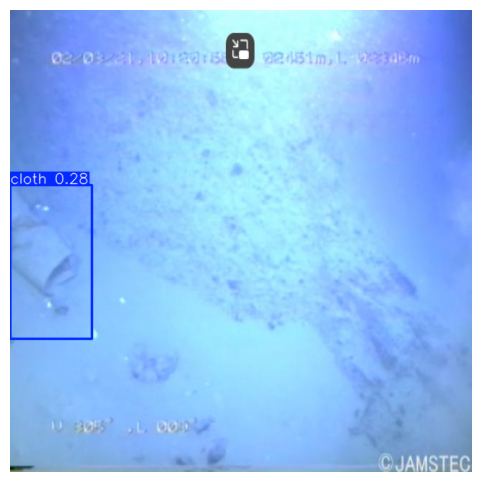

In [12]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import glob

def visualize_results(img_path, model):
    img = Image.open(img_path)
    results = model(img)

    # Extract the first result and get the plotted image
    result_img = results[0].plot()

    # Convert image to NumPy array if it's not already
    result_img = np.array(result_img)

    # Convert BGR (OpenCV default) to RGB for correct display in matplotlib
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # Show image with bounding boxes
    plt.figure(figsize=(6,6))
    plt.imshow(result_img)
    plt.axis("off")
    plt.show()
    plt.pause(0.001)  # Force display update
    plt.close()  # Prevent duplicate figures

# Load test images
test_images = glob.glob("/content/drive/MyDrive/My First Project.v15i.yolov11/test/images/*.jpg")

# Run visualization
if test_images:
    visualize_results(test_images[200], model)
else:
    print("No test images found.")

In [13]:
import glob
model_files = glob.glob("/content/runs/detect/*/weights/best.pt")
print("Available model files:", model_files)

Available model files: ['/content/runs/detect/train/weights/best.pt']


In [14]:
import glob

# List all training runs
train_folders = glob.glob("/content/runs/detect/*/")

print("Available training runs:")
for folder in train_folders:
    print(folder)

Available training runs:
/content/runs/detect/train/
/content/runs/detect/train2/


In [15]:
import glob

# Check logs inside different training folders
for folder in train_folders:
    log_files = glob.glob(folder + "/*.csv")
    if log_files:
        print(f"✅ Logs found in: {folder}")
        print(log_files)
    else:
        print(f"❌ No CSV logs found in: {folder}")

✅ Logs found in: /content/runs/detect/train/
['/content/runs/detect/train/results.csv']
❌ No CSV logs found in: /content/runs/detect/train2/


Available columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


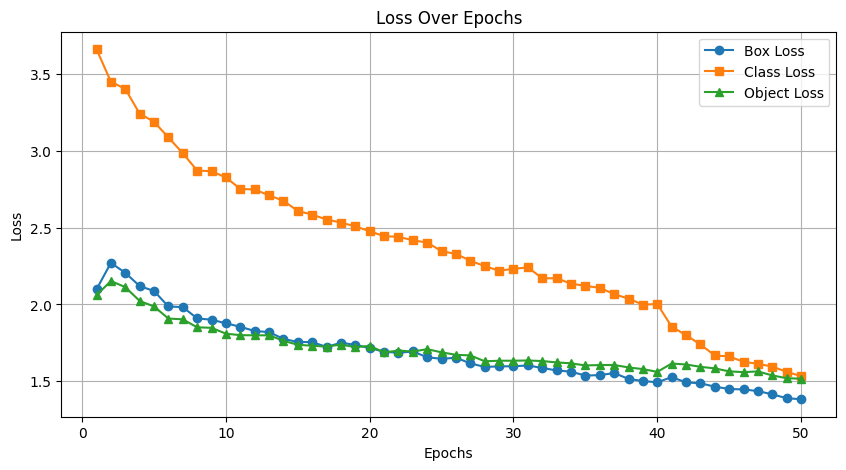

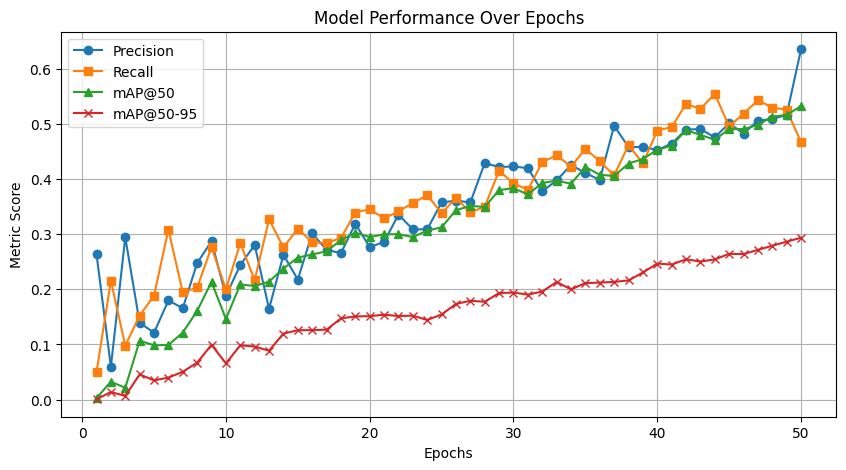

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Load the CSV file
csv_path = "/content/runs/detect/train/results.csv"
df = pd.read_csv(csv_path)

# Print column names to check available metrics
print("Available columns:", df.columns)

# ✅ Force Matplotlib to display the figures
def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss", marker='o')
    plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss", marker='s')
    plt.plot(df["epoch"], df["train/dfl_loss"], label="Object Loss", marker='^')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

def plot_accuracy():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision", marker='o')
    plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall", marker='s')
    plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50", marker='^')
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='x')

    plt.xlabel("Epochs")
    plt.ylabel("Metric Score")
    plt.title("Model Performance Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

# ✅ Call the functions
plot_loss()
plot_accuracy()


In [17]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Evaluate on the test dataset
metrics = model.val(data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml", split="test")

# Extract performance metrics
print("mAP50:", metrics.box.map50)      # Mean Average Precision at IoU 0.5
print("mAP50-95:", metrics.box.map)     # Mean Average Precision at IoU 0.5:0.95
print("Precision:", metrics.box.p.mean())   # Mean Precision across all classes
print("Recall:", metrics.box.r.mean())  # Mean Recall across all classes
print("F1 Score:", metrics.box.f1.mean())  # Mean F1 Score

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12m summary (fused): 169 layers, 20,107,996 parameters, 0 gradients, 67.1 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/test/labels.cache... 266 images, 46 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:08<00:00,  1.97it/s]


                   all        266        321      0.538      0.484      0.517      0.259
                 cloth         46         70      0.446       0.46      0.492      0.283
                 glass         59         59       0.73      0.734      0.778      0.393
                 metal         45         56      0.469      0.339      0.371      0.159
               plastic         82        136      0.506      0.404      0.424      0.203
Speed: 1.1ms preprocess, 12.4ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val
mAP50: 0.5165185547321625
mAP50-95: 0.25948283973015346
Precision: 0.5376648524442544
Recall: 0.48430341020411727
F1 Score: 0.506947564547916


In [19]:
import shutil

# Define source and destination paths
source_path = "/content/runs/detect/train/weights/best.pt"
destination_path = "/content/yolov12.mpt"

# Ensure the destination folder exists
shutil.os.makedirs("/content/drive/My Drive/saved_models", exist_ok=True)

# Copy the trained model to Google Drive
shutil.copy(source_path, destination_path)

print(f"✅ Model successfully saved to: {destination_path}")

✅ Model successfully saved to: /content/yolov12.mpt
